## <center> Data Generator </center>

### <center> Polytechnic University of Leiria </center>

#### <center> Patrícia Isabel Santos Martinho </center>

Libraries

In [108]:

#from benfordslaw import benfordslaw # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import chi2
from scipy.stats import entropy  # Função para calcular KL
import pandas as pd

Variable Initialization

In [109]:
colunas=1000 # features
linhas=1000 # instances
prop_linhas_manipuladas=0.3 # proportion of anomalous rows
prop_manipul_linha=0.1 # anomalies in an anomalous row
intensidade_uniforme=1 # intensity (uniform noise)
intensidade_gauss=10 # intensity (gaussian noise)
prop_outliers=0.05
faixa_outlier=(100000, 500000) # band of outliers
np.random.seed(1666)
alpha=0.05

linhas_manipuladas=int(linhas*prop_linhas_manipuladas) # absolute amount of anomalous rows
print(linhas_manipuladas)
linhas_s_fraude=linhas-linhas_manipuladas # absolute amount of BL conform rows
print(linhas_s_fraude)
qtde_fraude_linhaF=int(colunas*prop_manipul_linha) # absolute amount of anomalies in an anomalous row 
qtde_ben_linhaF=int(colunas*(1-prop_manipul_linha)) # absolute amount of BL conform numbers in an anomalous row 



300
700


Funções

In [110]:
# Funcion to generator BL conform numbers
def gerar_num_benford (n):
    uniforme=np.random.uniform(low=0, high=1, size=n)
    bfl_numb=10**uniforme
    return bfl_numb

In [111]:
# Function to get the first digit of a number
def obter_primeiro_digito(numero):
    num = abs(numero)  # Work only with positive values
    if num == 0:
        return 0
    while num < 1:  # If it is a small decimal number, multiply until it has a digit in the whole part
        num *= 10
    while num >= 10:  # If it is a large number, divide until on only one digit
        num //= 10
    return int(num)  # Returns the first digit as an integer


In [112]:
# Function to save the first digits
def array_primeiros_digitos (numeros):
    primeiros_digitos=[]
    for numero in numeros:
        primeiros_digitos.append(obter_primeiro_digito(numero))
    primeiros_digitos = [x for x in primeiros_digitos if x != 0]
    return primeiros_digitos


In [113]:
# Function to calculate the frequencies of the first digits
def frequencia_primeiros_digitos(numeros):
    frequencias = np.zeros(9)  # To store the frequencies of digits 1 through 9
    for numero in numeros:
        primeiro_digito = obter_primeiro_digito(numero)
        frequencias[primeiro_digito - 1] += 1  # Increases the digit count
    return frequencias


In [114]:
# Function to calculate the distribution expected by Benford’s Law
def distribuicao_benford(n):
    distribution = np.log10(1 + 1 / np.arange(1, 10))  # Benford’s law for digits 1 to 9
    distribution[-1] = 1 - sum(distribution[:-1])  # Adjusts the last probability
    return distribution*n

In [115]:
# Calculate accumulated frequencies from absolute frequencies

def f_acumulada (f_relativas):
    f_acumuladas=[]
    f_acumuladas.append(f_relativas[0])
    for i in range(1,len(f_relativas)):
        f_acumuladas.append(f_relativas[i]+f_acumuladas[i-1])
    return f_acumuladas


In [116]:
#  Gaussian noise

def adicionar_ruido_gaussiano(dados, intensidade):
    """Adiciona ruído gaussiano aos dados"""
    ruido = np.random.normal(0, intensidade, len(dados))
    return dados + ruido

In [117]:
# Uniform noise

def adicionar_ruido_uniforme(dados, intensidade):
    """Adiciona ruído uniforme aos dados"""
    ruido = np.random.uniform(-intensidade, intensidade, len(dados))
    return dados + ruido

In [118]:
# Mixed noise (gaussin noise + uniform noise)

def adicionar_ruido_misto(dados, intensidade_gauss, intensidade_uniforme):
    """Adiciona uma mistura de ruído gaussiano e uniforme aos dados"""
    ruido_gaussiano = np.random.normal(0, intensidade_gauss, len(dados))
    ruido_uniforme = np.random.uniform(-intensidade_uniforme, intensidade_uniforme, len(dados))
    return dados + ruido_gaussiano + ruido_uniforme

In [119]:
# Outliers

def adicionar_outliers(dados, proporcao, faixa_outlier):
    """Adiciona outliers moderados ou extremos ao conjunto de dados"""
    n_outliers = int(len(dados) * proporcao)
    indices = np.random.choice(range(len(dados)), n_outliers, replace=False) # replace=falss means without repeating
    for i in indices:
        dados[i] = np.random.uniform(*faixa_outlier)
    return dados

In [120]:
# Absolute mean deviation

def calcular_mad(observadas, esperadas):
    return np.mean(np.abs(observadas - esperadas))

In [121]:
# Kolmogorov-smirnov

def calcular_ks (observadas, esperadas):

    # Calculate accumulated frequencies
    obs_acum=np.array(f_acumulada(observadas))
    esp_acum=np.array(f_acumulada(esperadas))
    
    # Calculate distance
    return np.max(np.abs(obs_acum - esp_acum))

In [122]:
# Euclidean distance

def calcular_euclidiana (observadas, esperadas):
    return np.sqrt(np.sum((observadas - esperadas) ** 2))

In [123]:
# Hellinger distance

def calcular_hellinger(observadas, esperadas):
    return np.sqrt(0.5 * np.sum((np.sqrt(observadas) - np.sqrt(esperadas))**2))

In [124]:
# Kullback-Leiber divergence

def calcular_kl(observadas, esperadas):
    # Calculate KL Divergence
    kl_value = entropy(observadas, esperadas)  # scipy.stats.entropy calculates KL when we pass two distributions
    
    return kl_value

In [125]:
# Hypothesis tests

def teste_hipoteses (teste, observacoes, numero_simulacoes):
        # Expected frequencies for Benford’s Law
    esperadas = distribuicao_benford(numero_simulacoes)
    esperadas_norm=esperadas/sum(esperadas)

    # Generate samples that follow Benford’s Law
    valores_simulados = []

    for _ in range(numero_simulacoes):
        simulados = np.random.choice(np.arange(1, 10), p=np.array(esperadas_norm), size=int(sum(observacoes)))
        freq_simuladas = [np.sum(simulados == d) for d in range(1, 10)]
        match teste:
            case "mad":
                mad_simulado = calcular_mad(freq_simuladas, esperadas)
                valores_simulados.append(mad_simulado)
            case "ks":
                ks_simulado= calcular_ks(freq_simuladas,esperadas)
                valores_simulados.append(ks_simulado)
            case "euc":
                euclidiana_simulado= calcular_euclidiana(freq_simuladas,esperadas)
                valores_simulados.append(euclidiana_simulado)
            case "hel":
                hellinger_simulado= calcular_hellinger(freq_simuladas,esperadas)
                valores_simulados.append(hellinger_simulado)
            case "kl":
                kl_simulado= calcular_kl(freq_simuladas,esperadas)
                valores_simulados.append(kl_simulado)

        

     # calculate observed value:
    match teste:
        case "mad":
            valor_observado = calcular_mad(observacoes, esperadas)
        case "ks":
            valor_observado= calcular_ks(observacoes,esperadas)
        case "euc":
            valor_observado = calcular_euclidiana(observacoes, esperadas)
        case "hel":
            valor_observado = calcular_hellinger(observacoes, esperadas)
        case "kl":
            valor_observado = calcular_kl(observacoes, esperadas)
        

    # Calculate p-value
    p_value_teste = np.mean(np.array(valores_simulados) >= valor_observado) # proportion of values higher than expected.

    return(valor_observado,p_value_teste)

In [126]:

def Fisher(p_values):

    fisher_stat = -2 * sum(np.log(p_values))
    if fisher_stat == float('-inf'):
        print(p_values)
    combined_p_value = 1 - chi2.cdf(fisher_stat, 2 * len(p_values)) # chi2.cdf -> cumulative chi2 distribution
    return combined_p_value

In [127]:
# I did this function to solve situations of incomplete confusion matrices and avoid errors

def matriz_confusao(class_real, previsto):
    # Generate the confusion matrix
    labels = [0, 1]  # Expected classes
    conf_matrix = confusion_matrix(class_real, previsto, labels=labels)

    tn, fp, fn, tp = 0, 0, 0, 0

    # Direct extraction of values if both classes exist
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:  # If there is only one class in the data
        if 0 in class_real:
            tn = conf_matrix[0, 0] if conf_matrix.shape[0] > 0 else 0
            fp = conf_matrix[0, 1] if conf_matrix.shape[1] > 1 else 0
        if 1 in class_real:
            fn = conf_matrix[1, 0] if conf_matrix.shape[0] > 1 else 0
            tp = conf_matrix[1, 1] if conf_matrix.shape[1] > 1 else 0
    
    return tn, fp, fn, tp, conf_matrix

In [128]:
# draw the confusion matrix

def desenhar_matriz_confusão (class_real, previsto):
      # Actual class count in the data
    unique, counts = np.unique(class_real, return_counts=True)
    class_counts = dict(zip(unique, counts))

    tn, fp, fn, tp, conf_matrix  = matriz_confusao(class_real, previsto)

    # Display the confusion matrix
    print("Matriz de Confusão :")
    print('VN   FP')
    print('FN   VP')
    print(' ')
    print(conf_matrix)
    print('--------------')
    print('Classificação real')
    print("Negativos (linhas manipuladas):", class_counts.get(0, 0))
    print("Positivos (linhas sem manipulação):", class_counts.get(1, 0))
    print("---------------------------")
    print("---------------------------")
    print("(tn, fp, fn, tp) =", (tn, fp, fn, tp))

In [129]:
def gerar_roc(class_real, p_values, alpha_values):
    fprs = []
    tprs = []

    p_values = p_values.flatten()  # Ensure that p_values is a one-dimensional vector

    # Calculate overall ROC and AUC before loop (to avoid unnecessary calculations)
    fpr_full, tpr_full, _ = roc_curve(class_real, p_values)
    auc_value = auc(fpr_full, tpr_full)
    print(f"AUC total: {auc_value}")

    for alpha in alpha_values:  
        previsto = (p_values < alpha).astype(int) # positive values - with anomalies

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(class_real, previsto).ravel()

        # Calculate the rate of false positives and true positives
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  

        fprs.append(fpr)
        tprs.append(tpr)

    # Generate the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fprs, tprs, marker="o", label="ROC curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Reference line (random model)
    plt.xlabel("1-Specificity (FPR)")
    plt.ylabel("Sensibility (TPR)")
    plt.legend()
    plt.grid()
    plt.show()

    return np.array(fprs), np.array(tprs), np.array(alpha_values)




In [130]:
# Draw chart of the proportions of the digits

def grafico_digitos (dados,nl):
    # Creation of the figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))

    # Data for the Benford’s Law chart
    prop_ds = np.array(dados[nl,:-1])
         
    # Calculate the frequency of the first digits
    xv = range(1, 10)
    yv = distribuicao_benford(colunas)
    yv = yv/colunas

    # Plot the proportions according to Benford’s Law as a line
    ax.plot(xv, yv, marker='o', label="Benford's Law Distribution", linestyle='-', color='blue', alpha=0.6)

    # Notes for the values of Benford’s Law
    for i, value in enumerate(yv):
        ax.annotate(f'{value:.3f}',  # Round the annotation to 3 decimal places
                    xy=(xv[i], value),
                    xytext=(0, 5),  # Offset at the annotation position
                    textcoords='offset points',
                    ha='center',
                    va='bottom')

    # Data for the dataset chart
 
    x = list(range(1, 10)) 
    y = frequencia_primeiros_digitos(prop_ds)
    y = y/len(prop_ds)

    # Plot the proportions of the dataset as a line
    ax.plot(x, y, marker='o', label=f"Digits frequency in line nr. {nl}", linestyle='-', color='orange', alpha=0.6)

    # Annotations for the dataset values
    for i, value in enumerate(y):
        ax.annotate(f'{value}',
                    xy=(x[i], value),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')

    # Axis and subtitle settings
    ax.set_xlabel("First Digit", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend(fontsize=14)
    ax.set_xticks(list(range(1, 10)))  # Defining x axis ticks
    ax.set_xticklabels(list(range(1, 10)))  # Labels for the ticks

    # display the graph
    plt.show()

Generate data

In [131]:
uniforme=np.random.uniform(low=0, high=1, size=colunas)
bfl_numb=10**uniforme 
result=np.append(bfl_numb,0) # follows the law of Benford, label 0
print(len(result))
print("----------------------")

i=1
i2=linhas_s_fraude+1
while i<linhas_s_fraude:
    bfl_numb=gerar_num_benford (colunas)
    bfl_numb=np.append(bfl_numb,0) # 0 --> no anomalies
    bfl_numb=abs(bfl_numb)
    result = np.vstack([result, bfl_numb])
    i=i+1

while i2 in range(linhas_s_fraude+1,linhas+1):
    ben_aux=gerar_num_benford (qtde_fraude_linhaF)
    #anom = adicionar_ruido_gaussiano(ben_aux, intensidade_gauss)
    #anom = adicionar_ruido_uniforme(ben_aux, intensidade_uniforme)
    #anom = adicionar_ruido_misto(ben_aux, intensidade_gauss, intensidade_uniforme)
    anom = adicionar_outliers(ben_aux, prop_outliers, faixa_outlier)
    anom=np.random.uniform(low=0, high=100000, size=qtde_fraude_linhaF)
    anom=abs(anom)
    ben=np.random.uniform(low=0, high=1, size=qtde_ben_linhaF)
    bfl_numb=10**ben
    bfl_numb=abs(bfl_numb)
    bfl_numb=np.append(bfl_numb,anom)
    bfl_numb=np.append(bfl_numb,1) # 1 --> with anomalies
    result = np.vstack([result, bfl_numb])
    i2=i2+1
df_result=pd.DataFrame(result)
df_final = df_result.sample(frac=1, random_state=42).reset_index(drop=True)
dados_finais=array = df_final.to_numpy()




1001
----------------------


In [132]:
dados_finais

array([[5.88977999e+00, 3.01191213e+00, 5.57809512e+00, ...,
        1.35510199e+00, 3.64438239e+00, 0.00000000e+00],
       [3.89204909e+00, 4.64110786e+00, 4.44649215e+00, ...,
        1.77855436e+04, 1.27960062e+04, 1.00000000e+00],
       [5.45850539e+00, 4.73905214e+00, 5.40053715e+00, ...,
        7.84743745e+04, 6.30706936e+04, 1.00000000e+00],
       ...,
       [1.89446840e+00, 3.70387968e+00, 2.61706604e+00, ...,
        8.67108150e+04, 5.55608058e+04, 1.00000000e+00],
       [3.88572531e+00, 5.34381855e+00, 2.09263360e+00, ...,
        1.05643121e+00, 7.26867828e+00, 0.00000000e+00],
       [8.50027186e+00, 3.32139842e+00, 5.88741999e+00, ...,
        1.43922368e+00, 3.99251661e+00, 0.00000000e+00]])

In [133]:
class_real = dados_finais[:, -1]
class_real=class_real.astype(int)
print(class_real)

[0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 

In [134]:
counts = np.bincount(class_real)
print("Negativos", counts[0])
print("Positivos", counts[1])

Negativos 700
Positivos 300


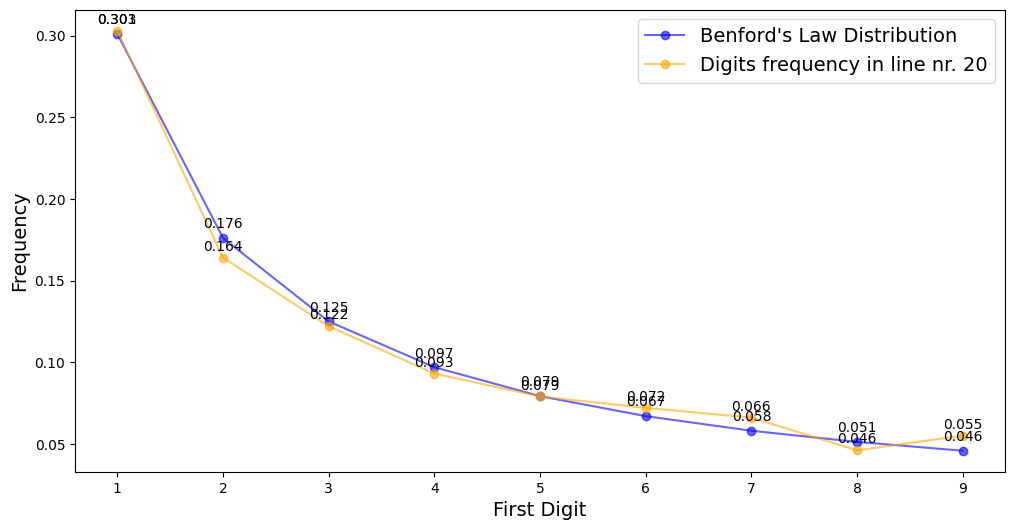

In [135]:
grafico_digitos (dados_finais,20)

In [136]:
type (dados_finais)

numpy.ndarray

In [ ]:
np.savetxt('Dataset.txt', dados_finais, delimiter=',')